# Classification Practice using MNIST Dataset

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- `DESCR` : key describing the dataset
- `data` : key containing an array with one row per instance and one column per feature
- `target` : key containing an array with labels

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

X, y = mnist["data"].copy(), mnist["target"].copy()
display(X.shape)
display(y.shape)

(70000, 784)

(70000,)

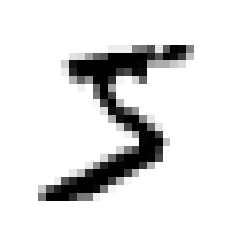

In [3]:
some_digit = X.loc[0]
some_digit_image = some_digit.values.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [4]:
y[0]

'5'

In [5]:
import numpy as np
y = y.astype(np.uint8)

## Split train and test data

In [11]:
X_train, X_test, y_train, y_test = X[:60000].copy(), X[60000:].copy(), y[:60000].copy(), y[60000:].copy()

## Training a Binary Classifier

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [8]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])

array([ True])

### Measuring Accuracy Using Cross-Validation

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.loc[train_index]
    y_train_folds = y_train_5.loc[train_index]
    X_test_fold = X_train.loc[test_index]
    y_test_fold = y_train_5.loc[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [18]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Above 93% accuracy on all cross-validation-folds? To confirm, create a classifier that just classifies every image in "not-5" class:

In [20]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

This tells that there are only around 10% of the images that are 5s.
This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with `skewed datasets` (i.e. when some classes are much more frequent than others)

### Confusion Matrix
A much better way to evaluate the performance of a classifier is to look at the `confusion matrix`.
The general idea is to count the number of times instance of class A are classified as class B.

In [22]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

The first row of this matrix considers non-5(`negative class`) images, the first column is `true negatives` and second column is for `false positives`.
The second row is for `positive class`, the first column is `false negatives` and second column is `true positives`

### Precision and Recall

In [26]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


It is often convenient sometimes to combine precision and recall into a single metric called the `F1 score`, in particular if you need a simple way to compare two classifiers.
The F1 score is the `harmonic mean` of precision and recall.
Harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.

In [27]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

Unfortunately, you cannot have both ways: increasing precision reduces recall, and vice versa. This is called the `precision/recall trade-off`.

## Precision/Recall Trade-off
For each instance, a classifier computes a score based on a `decision function`. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class.

You may retrieve the decision scores using `decision_function()` method, which returns a score for each instance, and then use any threshold you want to make predictions based on the scores:

In [28]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [29]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [30]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

### How do you decide which threshold to use?
First, use the `cross_val_predict()` function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of prediction:

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

With the se scores, use the `precision_recall_curve()` function to compute precision and recall for all possible thresholds:

In [32]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

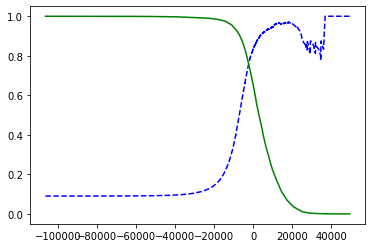

In [33]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

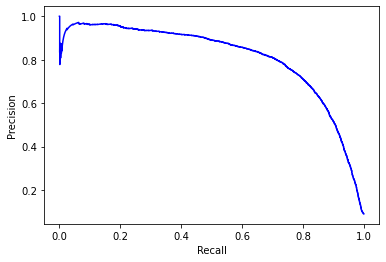

In [35]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
plot_precision_vs_recall(precisions, recalls)
plt.show()

Suppose you decide to aim for 90% precision. You can look for the lowest threshold that gives you at least 90% precision:

In [36]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [37]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [38]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [39]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

`Note`: A high-precision classifier is not very useful if its recall is too low. If someone says, "Let's reach 99% precision," you should ask, "At what recall?"

## ROC Curve
`Receiver Operating Characteristic` curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the `true positive rate`(another name for `recall`) agains the `false positive rate`.

In [40]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

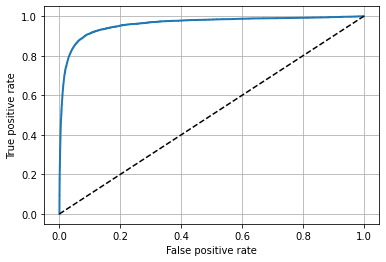

In [42]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.ylabel("True positive rate")
    plt.xlabel("False positive rate")
    plt.grid()
    plt.show()
plot_roc_curve(fpr, tpr)

One way to compare classifiers is to measure the `area under the curve(AUC)`. A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [43]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616